In [23]:
import pandas as pd
import numpy as np 
import pathlib
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from keras.layers import TimeDistributed
from keras.optimizers import Adam

In [24]:
# Loading the dataset 
data_dir = pathlib.Path('/home/lv11/Documents/ProyectosPython/sentimentAnalysis/datasets')
nf = pd.read_csv(data_dir / 'datasetFinal.csv',skiprows=1,names=['Message','Target'])
len(nf)

32654

In [25]:
nlp = English()
stop_words = list(STOP_WORDS)

messages = nf['Message']
labels = nf['Target']
#print(stop_words)

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != '-PRON-' else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuation ]
    return tokens

In [26]:
def vectorization(tweets):
    vector = CountVectorizer(tokenizer=spacy_tokenizer)
    frequency_matrix = vector.fit_transform(tweets)
    sum_frequencies = np.sum(frequency_matrix,axis=0)
    frequency = np.squeeze(np.asarray(sum_frequencies))
    frequency_dataFrame = pd.DataFrame([frequency],columns=vector.get_feature_names()).transpose()
    return frequency_dataFrame

In [27]:
def splitting(messages,labels):
    X_train,X_test,y_train,y_test = train_test_split(messages,labels,test_size=0.25,random_state=42,shuffle=True)
    return X_train,X_test,y_train,y_test

In [28]:
def tokenization_tweets(dataset,features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

In [29]:
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon,decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    history = model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=True)
    return model_nn, history

In [30]:
def test(X_test,model):
    predict = model.predict(X_test)
    return predict

In [31]:
def modelo1(X_train,y_train):
    features = 8320 #1554 #3199 1554 1727 # puede ser 3727 o un valor asi que vi como len() del array de X_train 
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 20
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train,features)
    modelo, history = train(X_train_mod, y_train,features,shuffle,drop,layer1,layer2,epoch,lr,epsilon,validation)
    return modelo, history

In [32]:
def modelo2(X_train,y_train):
    features = 6675 #3199 1554 1727 # puede ser 3727 o un valor asi que vi como len() del array de X_train 
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train,features)
    modelo, history = train(X_train_mod, y_train,features,shuffle,drop,layer1,layer2,epoch,lr,epsilon,validation)
    return modelo, history

In [33]:
frequency_dataFrame = vectorization(messages)

In [34]:
X_train,X_test,y_train,y_test = splitting(messages,labels)
len(X_train)

24490

In [35]:
modelo, history = modelo1(X_train,y_train)

Train on 22041 samples, validate on 2449 samples
Epoch 1/20
22041/22041 [==============================] - 61s 3ms/step - loss: 0.6563 - accuracy: 0.6154 - val_loss: 0.6197 - val_accuracy: 0.6227
Epoch 2/20
22041/22041 [==============================] - 60s 3ms/step - loss: 0.5420 - accuracy: 0.7112 - val_loss: 0.6188 - val_accuracy: 0.6301
Epoch 3/20
22041/22041 [==============================] - 77s 3ms/step - loss: 0.4714 - accuracy: 0.7501 - val_loss: 0.6773 - val_accuracy: 0.6141
Epoch 4/20
22041/22041 [==============================] - 75s 3ms/step - loss: 0.3996 - accuracy: 0.7795 - val_loss: 0.8101 - val_accuracy: 0.6370
Epoch 5/20
22041/22041 [==============================] - 77s 3ms/step - loss: 0.3432 - accuracy: 0.7966 - val_loss: 1.0177 - val_accuracy: 0.6439
Epoch 6/20
22041/22041 [==============================] - 76s 3ms/step - loss: 0.3021 - accuracy: 0.8140 - val_loss: 1.1894 - val_accuracy: 0.6399
Epoch 7/20
22041/22041 [==============================] - 76s 3ms/ste

In [36]:
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               4260352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 4,392,451
Trainable params: 4,392,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
input_data = tokenization_tweets(X_test,8320) #3727 1554
#input_data

In [38]:
pred = modelo.predict(input_data)
#X_test

In [39]:
xtest = [x for x in X_test]
for i in range(len(pred)):
    sent = (1 if pred[i][1] >0.5 else 0)
    print("tweet = %s, sentiment = %s" % (xtest[i],sent))

sn`t as scary as in the beginning, sentiment = 0
tweet = 525,600 recycled tiles...but will they be able to pay this year`s rent?   Broadway gets a 'green' theater.   http://bitly.com/3LoHVl, sentiment = 0
tweet =  Thank you.  Usually the learning happens after I get a little rest and review my notes.  Which reminds me, I`d better get some rest, sentiment = 0
tweet =  i agree with the whole Hollie thing, sentiment = 0
tweet = thanks iPhone, you kept me up till 1 am. ****., sentiment = 1
tweet =  Oh stop boasting already.  I`ve got a horrible piece o` **** cellphone.  *pulls a tongue*, sentiment = 1
tweet = awww  Lukes been evicted from the Quiz, sentiment = 0
tweet = Thinking of making a Google Wave wordpress plugin in the next months... Really want to test it, sentiment = 1
tweet =   I never followed him in the first  place!   He is a useless waste of space. and Im not a conservative! LOL, sentiment = 0
tweet = y'all want me to choke what'd I do? unhappy   ( , sentiment = 0
tweet =  di

In [40]:
i = 0
for y in y_test:
    print(xtest[i]," ---> ",y)
    i = i+1

a great weekend  --->  0
Sore throat. This is not good. I have four performances this weekend.  --->  1
 (RE:'your joint w/  is crazy!!') Thx    Hey Trax heard a 49er rear ended you??  --->  1
my back hurts sad   --->  0
Sad that I won`t see Deb for two days.  --->  0
_city tell brandon I said hi!!  --->  1
 happy bday to her  and happy mothers` day too  --->  1
Happy Mothers Day!!  --->  1
i ate waaaay to much candy today, i feel sick  --->  0
In lawmakers jump ship  --->  0
 my baby shut me down  --->  0
I ordered car yesterday  --->  0
 got on my favorite boot cut jeans and roshe runs. No girl is safe today. Have a blessed 4/20 all smile  --->  1
 Si seguisses als stormtroopers, a Jabba The Hut i a Death Star te n`hauries enterat abans que jo!  --->  0
 Taylor Swift I think you`re so pretty it makes my heart melt everytime I see your face.  --->  0
 good! you joined the dark side hahahaha we have cookies!  --->  0
Ate huge set of Appetizers. full now  --->  0
So sick >.< feeling ***

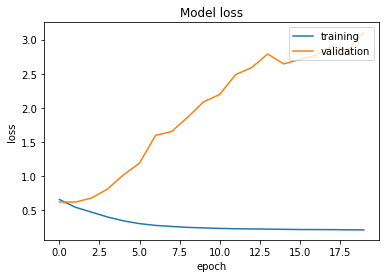

In [41]:
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'],loc='upper right')
plt.show()

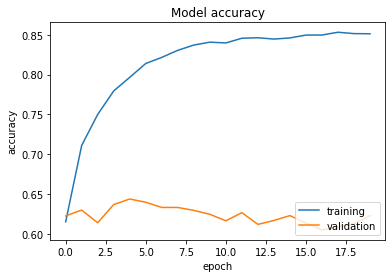

In [42]:
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [43]:
test_loss,test_acc = modelo.evaluate(input_data,y_test)

8164/8164 [==============================] - 2s 290us/step


In [44]:
print("test loss:", test_loss)
print("test accuracy:",test_acc)

test loss: 2.274646048800493
test accuracy: 0.5083292722702026
